# Interpolation with Rician Noise on DWI's

Code by:

Tyler Spears - tas6hh@virginia.edu

Dr. Tom Fletcher

---

Source works:

`Basu S, Fletcher T, Whitaker R. Rician Noise Removal in Diffusion Tensor MRI. In: Larsen R, Nielsen M, Sporring J, eds. Medical Image Computing and Computer-Assisted Intervention – MICCAI 2006. Vol 4190. Lecture Notes in Computer Science. Springer Berlin Heidelberg; 2006:117-125. doi:10.1007/11866565_15
`


# Imports & Environment Setup

## Imports

In [25]:
# Automatically re-import project-specific modules.
%load_ext autoreload
%autoreload 1

# imports
import collections
import itertools
import functools

import pathlib
from pathlib import Path
import shutil

import math
import random
import datetime
import time

import copy
import warnings
import pdb
import inspect
import sys

import os
import io
import subprocess

import dotenv

# Toolbelt/utility imports
import natsort
from natsort import natsorted
import addict
from addict import Addict
import pprint
from pprint import pprint as ppr
import tqdm
from tqdm import tqdm_notebook

# Computation & ML libraries.
import numpy as np
import scipy
import skimage
import skimage.feature
import skimage.filters
import skimage.measure
import nibabel as nib
import dipy
import dipy.viz
import dipy.align
import dipy.reconst
import ants
import pandas as pd

import torch
import torch.nn.functional as F
import torchvision
import torchio
import pytorch_lightning as pl

# visualization libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import IPython
from tabulate import tabulate
from IPython.display import display, Markdown

# Try importing GPUtil for printing GPU specs.
# May not be installed if using CPU only.
try:
    import GPUtil
except ImportError:
    warnings.warn("WARNING: Package GPUtil not found, cannot print GPU specs")

plt.rcParams.update({"figure.autolayout": True})
plt.rcParams.update({"figure.facecolor": [1.0, 1.0, 1.0, 1.0]})

# Set print options for ndarrays/tensors.
np.set_printoptions(threshold=100, linewidth=88)
torch.set_printoptions(precision=8, threshold=100, linewidth=88)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Update notebook's environment variables with direnv.
# This requires the python-dotenv package, and direnv be installed on the system
# This will not work on Windows.
# NOTE: This is kind of hacky, and not necessarily safe. Be careful...
# Libraries needed on the python side:
# - os
# - subprocess
# - io
# - dotenv

# Form command to be run in direnv's context. This command will print out
# all environment variables defined in the subprocess/sub-shell.
command = "direnv exec {} /usr/bin/env".format(os.getcwd())
# Run command in a new subprocess.
proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True, cwd=os.getcwd())
# Store and format the subprocess' output.
proc_out = proc.communicate()[0].strip().decode("utf-8")
# Use python-dotenv to load the environment variables by using the output of
# 'direnv exec ...' as a 'dummy' .env file.
dotenv.load_dotenv(stream=io.StringIO(proc_out), override=True);

direnv: loading ~/work/pitn/.envrc
direnv: creating conda environment

CondaValueError: prefix already exists: /opt/miniconda/envs/pitn



In [4]:
# Project-specific scripts
# It's easier to import it this way rather than make an entirely new package, due to
# conflicts with local packages and anaconda installations.
# You made me do this, poor python package management!!
if "PROJECT_ROOT" in os.environ:
    lib_location = str(Path(os.environ["PROJECT_ROOT"]).resolve())
else:
    lib_location = str(Path("../../").resolve())
if lib_location not in sys.path:
    sys.path.insert(0, lib_location)
import lib as pitn

# Include the top-level lib module along with its submodules.
%aimport lib
# Grab all submodules of lib, not including modules outside of the package.
includes = list(
    filter(
        lambda m: m.startswith("lib."),
        map(lambda x: x[1].__name__, inspect.getmembers(pitn, inspect.ismodule)),
    )
)
# Run aimport magic with constructed includes.
ipy = IPython.get_ipython()
ipy.run_line_magic("aimport", ", ".join(includes))

In [5]:
# torch setup
# allow for CUDA usage, if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
# keep device as the cpu
# device = torch.device('cpu')
print(device)

cuda


## Specs Recording

In [6]:
%%capture --no-stderr cap
# Capture output and save to log. Needs to be at the *very first* line of the cell.
# Watermark
%load_ext watermark
%watermark --author "Tyler Spears" --updated --iso8601  --python --machine --iversions --githash
# if torch.cuda.is_available():

#     # GPU information
#     # Taken from
#     # <https://www.thepythoncode.com/article/get-hardware-system-information-python>.
#     # If GPUtil is not installed, skip this step.
#     try:
#         gpus = GPUtil.getGPUs()
#         print("=" * 50, "GPU Specs", "=" * 50)
#         list_gpus = []
#         for gpu in gpus:
#             # get the GPU id
#             gpu_id = gpu.id
#             # name of GPU
#             gpu_name = gpu.name
#             driver_version = gpu.driver
#             cuda_version = torch.version.cuda
#             # get total memory
#             gpu_total_memory = f"{gpu.memoryTotal}MB"
#             gpu_uuid = gpu.uuid
#             list_gpus.append(
#                 (
#                     gpu_id,
#                     gpu_name,
#                     driver_version,
#                     cuda_version,
#                     gpu_total_memory,
#                     gpu_uuid,
#                 )
#             )

#         print(
#             tabulate(
#                 list_gpus,
#                 headers=(
#                     "id",
#                     "Name",
#                     "Driver Version",
#                     "CUDA Version",
#                     "Total Memory",
#                     "uuid",
#                 ),
#             )
#         )
#     except NameError:
#         print("CUDA Version: ", torch.version.cuda)

# else:
#     print("CUDA not in use, falling back to CPU")

In [7]:
# cap is defined in an ipython magic command
print(cap)

Author: Tyler Spears

Last updated: 2021-06-22T02:15:13.112050+00:00

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.23.1

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 5.4.0-72-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Git hash: b7712bdf9c695b66cab1a861f1252d2bb51e7666

sys              : 3.8.8 (default, Feb 24 2021, 21:46:12) 
[GCC 7.3.0]
skimage          : 0.18.1
IPython          : 7.23.1
matplotlib       : 3.4.1
torchio          : 0.18.37
tqdm             : 4.60.0
GPUtil           : 1.4.0
torchvision      : 0.9.1
dipy             : 1.4.0
numpy            : 1.20.2
natsort          : 7.1.1
ants             : 0.2.7
torch            : 1.8.1
scipy            : 1.5.3
nibabel          : 3.2.1
json             : 2.0.9
addict           : 2.4.0
seaborn          : 0.11.1
pandas           : 1.2.3
ipywidgets       : 7.6.3
pytorch_lightning: 1.3.2




## Data Variables & Definitions Setup

In [8]:
# Set up directories
data_dir = pathlib.Path(os.environ["DATA_DIR"]) / "hcp"
assert data_dir.exists()
write_data_dir = pathlib.Path(os.environ["WRITE_DATA_DIR"]) / "hcp"
assert write_data_dir.exists()
results_dir = pathlib.Path(os.environ["RESULTS_DIR"])
assert results_dir.exists()

In [9]:
# Dict to keep track of experiment configuration parameters. Will not be logged to
# tensorboard.
exp_params = Addict()

In [10]:
downsample_factor = 2
# Include b=0 shells and b=1000 shells for DTI fitting.
bval_range = (0, 3500)
dti_fit_method = "WLS"
exp_params.update(
    {
        "downsample_factor": downsample_factor,
        "bval_range": bval_range,
        "dti_fit_method": dti_fit_method,
    }
)

### Patch Parameters

In [11]:
# Patch parameters
# 6 channels for the 6 DTI components
channels = 6

# Output patch shapes
h_out = 14
w_out = 14
d_out = 14

# This is the factor that determines how over-extended the input patch should be
# relative to the size of the full-res patch.
# $low_res_patch_dim = \frac{full_res_patch_dim}{downsample_factor} \times low_res_sample_extension$
# A value of 1 indicates that the input patch dims will be exactly divided by the
# downsample factor. A dilation > 1 increases the "spatial extent" of the input
# patch, providing information outside of the target HR patch.
low_res_sample_extension = 1.57

# Output shape after shuffling.
output_patch_shape = (channels, h_out, w_out, d_out)
output_spatial_patch_shape = output_patch_shape[1:]

# Input patch parameters
h_in = round(h_out / (downsample_factor) * low_res_sample_extension)
w_in = round(w_out / (downsample_factor) * low_res_sample_extension)
d_in = round(d_out / (downsample_factor) * low_res_sample_extension)
input_patch_shape = (channels, h_in, w_in, d_in)
input_spatial_patch_shape = input_patch_shape[1:]

# Pre-shuffle output patch sizes.
unshuffled_channels_out = channels * downsample_factor ** 3
# Output before shuffling
unshuffled_output_patch_shape = (unshuffled_channels_out, h_in, w_in, d_in)

# Patch size in FR-space when accounting for the low-res over-extension/over-sampling
# factor.
fr_extension_patch_size = tuple(
    np.asarray(input_spatial_patch_shape) * downsample_factor
)
fr_extension_amount = tuple(
    np.asarray(fr_extension_patch_size) - np.asarray(output_spatial_patch_shape)
)

In [12]:
exp_params.patch.update(
    channels=channels,
    low_res_sample_extension=low_res_sample_extension,
    input_shape=input_patch_shape,
    output_shape=output_patch_shape,
)

In [13]:
# Data parameters.
num_subject_samples = 1

In [14]:
exp_params.data.update(
    num_subject=num_subject_samples,
)

### Training and Testing Setup

In [15]:
# Spline interpolation baseline parameters.
spline_interp_order = 1

In [16]:
# Number of voxels to dilate the mask in FR space.
# Just make it 0.
dilation_size = 0

In [17]:
exp_params.spline.update(order=spline_interp_order)
exp_params.preproc.update(dilation_size=dilation_size)

## Function Definitions

# Data Loading

## Subject ID Selection

In [18]:
# Find data directories for each subject.
subj_dirs: dict = dict()

selected_ids = [
    "397154",
    "224022",
    "140117",
    "751348",
    "894774",
    "156637",
    "227432",
    "303624",
    "185947",
    "810439",
    "753251",
    "644246",
    "141422",
    "135528",
    "103010",
    "700634",
]

## Sub-set the chosen participants for dev and debugging!
selected_ids = random.sample(selected_ids, num_subject_samples)
warnings.warn(
    "WARNING: Sub-selecting participants for dev and debugging. "
    + f"Subj IDs selected: {selected_ids}"
)
# ### A nested warning! For debugging only.
# warnings.warn("WARNING: Mixing training and testing subjects")
# selected_ids.append(selected_ids[0])
# ###
##

selected_ids = natsorted(list(map(lambda s: int(s), selected_ids)))

for subj_id in selected_ids:
    subj_dirs[subj_id] = data_dir / f"{subj_id}/T1w/Diffusion"
    assert subj_dirs[subj_id].exists()
subj_dirs

/tmp/ipykernel_123065/2765378097.py:25: UserWarning:




{810439: PosixPath('/mnt/storage/data/pitn/hcp/810439/T1w/Diffusion')}

## Loading and Preprocessing

In [19]:
# Set up the transformation pipeline.

preproc_transforms = torchio.Compose(
    [
        torchio.transforms.ToCanonical(include=("dwi", "brain_mask"), copy=False),
        pitn.transforms.BValSelectionTransform(
            bval_range=bval_range,
            bval_key="bvals",
            bvec_key="bvecs",
            include="dwi",
            copy=False,
        ),
        # Pad by the dilation factor, then dilate the mask.
        torchio.transforms.Pad(
            dilation_size,
            padding_mode=0,
            include=("dwi", "brain_mask"),
            copy=False,
        ),
        pitn.transforms.DilateMaskTransform(
            dilation_size=dilation_size, include=("brain_mask",), copy=False
        ),
        # Pad by the amount of extension voxels in FR space, so LR indices cannot
        # go out of bounds.
        torchio.transforms.Pad(
            fr_extension_amount,
            padding_mode=0,
            include=("dwi", "brain_mask"),
            copy=False,
        ),
        # Ensure FR dims are divisible by the downsample factor, to more reliably
        # convert between FR indices and LR indices.
        torchio.transforms.EnsureShapeMultiple(
            downsample_factor, method="pad", include=("dwi", "brain_mask"), copy=False
        ),
        pitn.transforms.MeanDownsampleTransform(
            downsample_factor,
            include=("dwi", "brain_mask"),
            keep={"dwi": "fr_dwi", "brain_mask": "fr_brain_mask"},
            copy=False,
        ),
        pitn.transforms.RenameImageTransform(
            {"dwi": "lr_dwi", "brain_mask": "lr_brain_mask"}, copy=False
        ),
        pitn.transforms.ImageToDictTransform(
            include=("lr_dwi", "lr_brain_mask"), copy=False
        ),
    ]
)

In [20]:
# Import all image data into a sequence of `torchio.Subject` objects.
subj_data: dict = dict()

for subj_id, subj_dir in subj_dirs.items():
    # Sub-select volumes with only bvals in a certain range. E.x. bvals <= 1100 mm/s^2,
    # a.k.a. only the b=0 and b=1000 shells.
    bvals = torch.as_tensor(np.loadtxt(subj_dir / "bvals").astype(int))
    bvecs = torch.as_tensor(np.loadtxt(subj_dir / "bvecs"))
    # Reshape to be N x 3
    if bvecs.shape[0] == 3:
        bvecs = bvecs.T

    brain_mask = torchio.LabelMap(
        subj_dir / "nodif_brain_mask.nii.gz",
        type=torchio.LABEL,
        channels_last=False,
    )
    brain_mask.set_data(brain_mask.data.bool())
    mask_volume = brain_mask["data"].sum()
    print(f"Brain mask volume before dilation: {mask_volume}")
    dwi = torchio.ScalarImage(
        subj_dir / "data.nii.gz",
        type=torchio.INTENSITY,
        bvals=bvals,
        bvecs=bvecs,
        reader=pitn.io.nifti_reader,
        channels_last=True,
    )

    subject_dict = torchio.Subject(subj_id=subj_id, dwi=dwi, brain_mask=brain_mask)
    preproced_subj = preproc_transforms(subject_dict)

    subj_data[subj_id] = preproced_subj
    print("=" * 20)
#     breakpoint()

print("===Data Loaded & Transformed===")

Brain mask volume before dilation: 829367
Loading NIFTI image: /mnt/storage/data/pitn/hcp/810439/T1w/Diffusion/data.nii.gz
	Loaded NIFTI image
Selecting with bvals: Subject 810439...Selected
Downsampling: Subject 810439...Downsampled
===Data Loaded & Transformed===


## Load UVA Data

In [21]:
# Load the UVA subject data
uva_data_dir = pathlib.Path(os.environ["DATA_DIR"]) / "uva"
assert uva_data_dir.exists()
uva_subj_dirs = dict()

for subj_dir in uva_data_dir.glob("*"):
    subj_id = subj_dir.name
    uva_subj_dirs[subj_id] = uva_data_dir / subj_id
    assert uva_subj_dirs[subj_id].exists()
uva_subj_dirs

{'001': PosixPath('/mnt/storage/data/pitn/uva/001')}

In [22]:
uva_subj_data: dict = dict()

for subj_id, subj_dir in uva_subj_dirs.items():
    # Sub-select volumes with only bvals in a certain range. E.x. bvals <= 1100 mm/s^2,
    # a.k.a. only the b=0 and b=1000 shells.
    bvals_file = list(subj_dir.glob("*.bval"))[0]
    bvecs_file = list(subj_dir.glob("*.bvec"))[0]
    bvals = torch.as_tensor(np.loadtxt(bvals_file).astype(int))
    bvecs = torch.as_tensor(np.loadtxt(bvecs_file))
    # Reshape to be N x 3
    if bvecs.shape[0] == 3:
        bvecs = bvecs.T

    dwi_file = list(subj_dir.glob("*dwi.nii.gz"))[0]
    dwi = torchio.ScalarImage(
        dwi_file,
        type=torchio.INTENSITY,
        bvals=bvals,
        bvecs=bvecs,
        reader=pitn.io.nifti_reader,
        channels_last=True,
    )

    gtab = dipy.core.gradients.gradient_table(bvals, bvecs)

    _, threshold_brain_mask = dipy.segment.mask.median_otsu(
        np.moveaxis(dwi.tensor.numpy(), 0, -1),
        vol_idx=np.where(bvals == 0)[0],
        median_radius=3,
        numpass=1,
        dilate=None,
    )

    brain_mask = torchio.LabelMap(
        tensor=torch.as_tensor(threshold_brain_mask[None, ...]),
        affine=dwi.affine,
        type=torchio.LABEL,
    )
    brain_mask.set_data(brain_mask.data.bool())

    subject_dict = torchio.Subject(subj_id=subj_id, dwi=dwi, brain_mask=brain_mask)
    preproced_subj = preproc_transforms(subject_dict)

    uva_subj_data[subj_id] = preproced_subj
    print("=" * 20)

Loading NIFTI image: /mnt/storage/data/pitn/uva/001/sub-001_ses-01_run-2_dwi.nii.gz
	Loaded NIFTI image
Selecting with bvals: Subject 001...Selected
Downsampling: Subject 001...Downsampled


# Rician Noise Definitions

$ \log p(x ; \nu) = \log \frac{x}{\sigma^2} -\frac{x^2 + \nu^2}{2\sigma^2} +
\log I_0\left(\frac{x\nu}{\sigma^2}\right) $

(array(6.12572294), array(10.2455184))


23.04

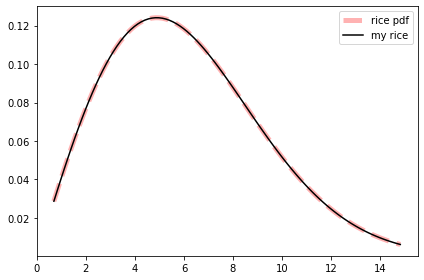

In [96]:
# # How to scale parameters of Rician pdf to include variance of the Gaussian noise?


# def pdf_noise_var(x, b, noise_var):
#     result = x / noise_var
#     result = result * np.exp(-(x ** 2 + b ** 2) / (2 * noise_var))
#     result = result * scipy.special.i0(x * b / noise_var)

#     return result


# b = 1.3
# sigma = 4.8
# rice_rv = scipy.stats.rice(b=b / sigma, scale=sigma)
# print(rice_rv.stats(moments="mv"))
# x = np.linspace(rice_rv.ppf(0.01), rice_rv.ppf(0.99), 100)

# plt.plot(x, rice_rv.pdf(x), "r--", lw=5, alpha=0.3, label="rice pdf")
# plt.plot(x, pdf_noise_var(x, b, sigma ** 2), label="my rice", color="black")
# plt.legend()
# sigma ** 2

In [364]:
# Patch-wise interpolation


def rician_interpolate(patches, interp_kernels, noise_var: float, init_pred=None):

    B = patches.shape[0]
    if len(interp_kernels.shape) == len(patches.shape) - 1:
        interp_kernels = np.repeat(interp_kernels[None, ...], B, axis=0)

    samples = patches.reshape(B, -1)
    N = samples.shape[1]

    weights = interp_kernels.reshape(B, N)
    #     breakpoint()
    if init_pred is None:
        init_pred = np.sum(samples * weights, axis=1)

    nu_0 = np.asarray(init_pred).reshape(B, 1)

    fit_fn = lambda x_and_init: (
        scipy.stats.rice.fit(
            x_and_init[:-1],
            x_and_init[-1],
            floc=0,
            fscale=np.sqrt(noise_var),
        )[0]
    )

    result = list()
    for sample_i, nu_0i in zip(samples, nu_0):
        #         result.append(nu_0i)
        result.append(fit_fn(np.concatenate([sample_i, nu_0i], axis=-1)))
    result = np.asarray(result)
    #     result = skimage.util.apply_parallel(
    #         fit_fn, np.concatenate([samples, nu_0], axis=-1), dtype=np.float32,
    #     )

    return result

In [296]:
# Perform interpolation of a volume given floating-point 3D coordinates.


def rician_interp_coords(vol, coords, noise_var, pad_mode="constant", cval=0.0):
    """
    Parameters:
        vol: np.ndarray, D x H x W
        coords: np.ndarray, 3 x (D_1 x D_2 x ...)
            The first dimension should have an ordering of `(Z Y X)`
        noise_var: float
    """
    coords = np.asarray(coords)
    batch_coords = coords.reshape(3, -1)
    batch_coords = batch_coords.T
    vol = np.asarray(vol)
    B = batch_coords.shape[0]

    # Pad the volume for any coords that index out-of-bounds.
    # Pad left/bottom/back
    lower_padding = np.ceil(
        np.clip(-batch_coords.min(axis=0), a_min=0, a_max=np.inf)
    ).astype(int)
    # Pad right/top/front
    upper_padding = (
        np.ceil(
            np.clip(
                batch_coords.max(axis=0) - (np.asarray(vol.shape) - 1),
                a_min=0,
                a_max=np.inf,
            )
        ).astype(int)
        + 1
    )
    pad_vol = np.pad(
        vol,
        tuple(zip(lower_padding, upper_padding)),
        mode=pad_mode,
        constant_values=cval,
    )
    # Offset previous coordinates with the lower padding values.
    batch_coords = batch_coords + lower_padding[None, ...]

    # Find coordinates of voxels neighboring the desired coordinate.
    z_0 = np.floor(batch_coords[:, 0]).astype(int)
    z_1 = np.ceil(batch_coords[:, 0] + 1e-8).astype(int)
    y_0 = np.floor(batch_coords[:, 1]).astype(int)
    y_1 = np.ceil(batch_coords[:, 1] + 1e-8).astype(int)
    x_0 = np.floor(batch_coords[:, 2]).astype(int)
    x_1 = np.ceil(batch_coords[:, 2] + 1e-8).astype(int)

    #     breakpoint()
    # Sample all the points needed for interpolation.
    p = list()
    # itertools.product considers the right-most element as changing the most
    # often, opposite to that of numpy dimensions. So, z and x need to be
    # swapped.
    for (x, y, z) in itertools.product((x_0, x_1), (y_0, y_1), (z_0, z_1)):
        p.append(pad_vol[(z, y, x)])
    p = np.asarray(p).T

    # Order the known point coordinates for all possible combinations.
    z_v = np.tile(np.repeat(np.asarray([z_0, z_1]).T, repeats=1, axis=-1), 4)
    y_v = np.tile(np.repeat(np.asarray([y_0, y_1]).T, repeats=2, axis=-1), 2)
    x_v = np.tile(np.repeat(np.asarray([x_0, x_1]).T, repeats=4, axis=-1), 1)

    # Construct weight vector as the volume of the shape opposite the point's location.
    w_v = (
        (1 - np.abs(batch_coords[:, 0][:, None] - z_v))
        * (1 - np.abs(batch_coords[:, 1][:, None] - y_v))
        * (1 - np.abs(batch_coords[:, 2][:, None] - x_v))
    )

    mle_interp = list()
    for sample, weights in tqdm.tqdm(zip(list(p), list(w_v)), total=len(w_v)):
        #         breakpoint()
        # If all voxels are 0, then MLE will always return 0, so might as well save that
        # computation.
        if (sample == 0).all():
            estimate = np.asarray(
                [
                    0.0,
                ]
            )
        else:
            estimate = rician_interpolate(
                sample[None, ...], weights, noise_var=noise_var
            )

        mle_interp.append(estimate)
    #     breakpoint()
    mle_interp = np.asarray(mle_interp).reshape(*coords.shape[1:])

    return mle_interp

In [278]:
def pull_coords(target_coords, backward_affine):
    """
    Convert coordinates in the transformed image domain to the pre-image domain.

    Parameters:
        target_coords: np.ndarray, shape 3 x (N_1 x N_2 x N_3 x ...)
            Coordinates of the transformed image.

        backward_affine: np.ndarray, shape 4 x 4
            Affine matrix that describes transform from transformed image coordinates
                to the pre-image coordinates.
    """
    # Assume homogeneous coordinates
    transform = backward_affine[:-1, :-1]
    translate = backward_affine[-1, :-1]

    coords = target_coords.transpose(*range(1, target_coords.ndim), 0)
    pre_coords = np.einsum("ij,...j -> ...i", transform, coords)
    pre_coords = pre_coords + translate[None, :]

    pre_coords = pre_coords.transpose(-1, *range(0, target_coords.ndim - 1))
    return pre_coords

# Rician MLE Interpolation

## Basic Center-Pixel Interpolation

In [ ]:
# # Select a specific plane and visualize it.
# dwi_plane = uva_subj_data["001"].fr_dwi.tensor.numpy()[50, :, :, 50]
# mask = uva_subj_data["001"].fr_brain_mask.tensor.numpy()[0, :, :, 50].astype(bool)

# plt.figure()
# plt.imshow(dwi_plane)
# plt.colorbar()

# plt.figure()
# plt.imshow(mask)

# # What is actually removed with the mask?
# plt.figure()
# plt.imshow(dwi_plane * ~mask)
# plt.colorbar()

In [ ]:
# # Capture just the air around the skull, not the skull itself.
# # Expand the mask to encompass the skull.
# air_mask = ~skimage.morphology.binary_dilation(mask, selem=skimage.morphology.disk(15))
# air_data = dwi_plane * air_mask
# plt.figure()
# plt.imshow(air_data)
# plt.colorbar()

# # Highlight where the actual 0's are, and make sure we aren't throwing away data that are
# # actually 0-valued.
# a = air_data.copy()
# a[a == 0] = a.max() * 2
# plt.figure()
# plt.imshow(a)
# plt.colorbar()

In [ ]:
# # Prep parameters.
# # Estimate noise variance.
# noise_vox = air_data[air_data != 0]
# noise_var = np.mean(noise_vox ** 2) / 2
# print(noise_var)

# # Construct the interpolation kernel.
# kernel = np.ones((3, 3))
# kernel[1, 1] = 0
# kernel = kernel / kernel.sum()
# print(kernel)

# # Break up dwi plane into patches with a simple tri-linear interpolation kernel, with the center
# # removed.
# mask_coords = np.asarray(np.where(mask))
# comparison_window = dwi_plane[
#     mask_coords[0].min() : mask_coords[0].max(),
#     mask_coords[1].min() : mask_coords[1].max(),
# ]

# patches = skimage.util.view_as_windows(comparison_window, kernel.shape, step=1)
# patches = patches.reshape(-1, *kernel.shape)

# mle_pred = rician_interpolate(patches, kernel, noise_var)

In [ ]:
# plt.figure()
# plt.imshow(mle_pred.reshape(61, 78), interpolation=None)
# plt.colorbar()
# plt.axis("off")

# plt.figure()
# B = patches.shape[0]
# test_kernels = np.repeat(kernel[None, ...], B, axis=0)
# interp = np.sum(patches * test_kernels, axis=(-1, -2))
# plt.imshow(interp.reshape(61, 78))
# plt.axis("off")
# plt.colorbar()

# plt.figure()
# plt.imshow(
#     np.sqrt((mle_pred.reshape(61, 78) - interp.reshape(61, 78)) ** 2),
#     interpolation=None,
# )
# plt.axis("off")
# plt.colorbar();

In [ ]:
# plt.figure()
# plt.imshow(comparison_window[1:-1, 1:-1], interpolation=None)
# plt.colorbar()
# plt.axis("off")

# plt.figure()
# plt.imshow(
#     np.sqrt(
#         (
#             comparison_window[1:-1, 1:-1] / (comparison_window[1:-1, 1:-1].max())
#             - mle_pred.reshape(61, 78) / (mle_pred.max())
#         )
#         ** 2
#     ),
#     interpolation=None,
# )
# plt.colorbar()
# plt.axis("off")

## Interpolation Over Affine Rotation Matrices

In [378]:
torch.where(subj_data[810439].fr_dwi['bvals'] == 3005)

(tensor([  3,  20,  28,  33,  42,  60,  73, 127, 153, 162, 164, 188]),)

In [381]:
subj = subj_data[810439]
pre_img = subj.fr_dwi.tensor.numpy()[3, ...]
noise_vox = pre_img[13:23, 13:23, 13:23]
noise_var = np.mean(noise_vox ** 2) / 2
noise_var

0.0

In [382]:
pre_img.shape

(162, 190, 162)

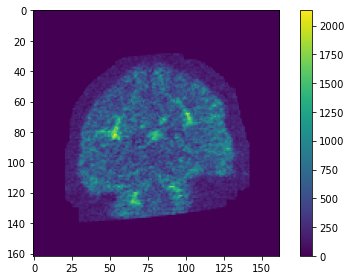

In [385]:
plt.imshow(np.rot90(pre_img[:, 80]))
plt.colorbar()

---

In [258]:
subj = uva_subj_data["001"]

pre_img = subj.fr_dwi.tensor.numpy()[65, ...]

# Calculate the noise variance from the non-masked voxels.
mask = subj.fr_brain_mask.tensor.numpy()[0].astype(bool)

air_mask = ~skimage.morphology.binary_dilation(mask, selem=skimage.morphology.ball(5))
air_data = pre_img * air_mask

noise_vox = air_data[air_data != 0]
noise_var = np.mean(noise_vox ** 2) / 2
print(noise_var)

79.85702514648438


In [369]:
air_mask = ~skimage.morphology.binary_dilation(mask, selem=skimage.morphology.ball(5))
air_data = pre_img * air_mask

noise_vox = air_data[13:23, 13:23, 13:23]
noise_var = np.mean(noise_vox ** 2) / 2
print(noise_var)

11.366999626159668


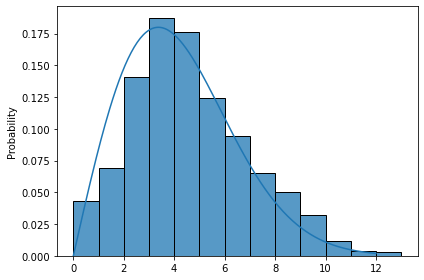

In [375]:
sns.histplot(noise_vox.flatten(), stat='probability', bins=13)
plt.plot(np.linspace(0, 12, num=200), scipy.stats.rice.pdf(np.linspace(0, 12, num=200), 0, scale=np.sqrt(noise_var)))

In [374]:
noise_vox.shape

(10, 10, 10)

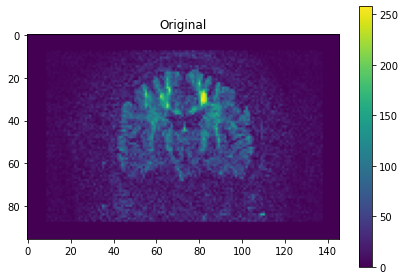

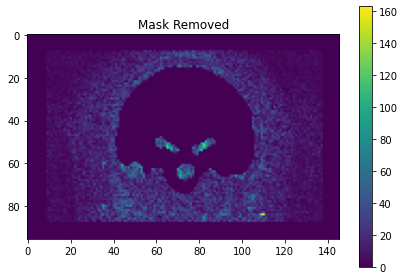

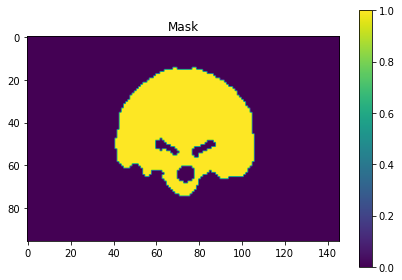

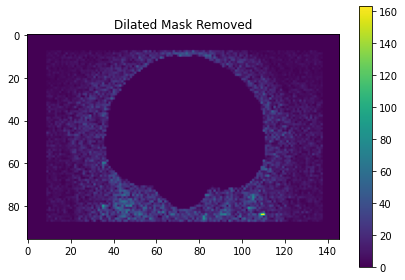

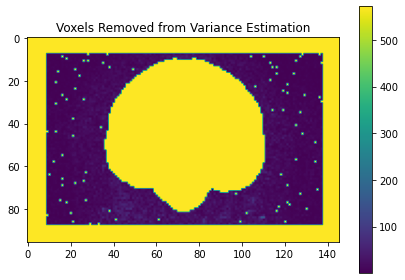

In [322]:
# Double-check the mask
plt.figure()
plt.title("Original")
plt.imshow(np.rot90(pre_img[:, 148 // 2]))
plt.colorbar()

plt.figure()
plt.title("Mask Removed")
plt.imshow(np.rot90((pre_img * ~mask)[:, 148 // 2]))
plt.colorbar()

plt.figure()
plt.title("Mask")
plt.imshow(np.rot90(mask[:, 148 // 2]))
plt.colorbar()

plt.figure()
plt.title("Dilated Mask Removed")
plt.imshow(np.rot90(air_data[:, 148 // 2]))
plt.colorbar()

# Highlight where the actual 0's are, and make sure we aren't throwing away data that are
# actually 0-valued.
a = air_data.copy()
a[a == 0] = a.max() * 2
plt.figure()
plt.title("Voxels Removed from Variance Estimation")
plt.imshow(np.rot90(a[:, 148 // 2]))
plt.colorbar()

In [324]:
space_shape = tuple(pre_img.shape)
coords = np.mgrid[0 : space_shape[0], 0 : space_shape[1], 0 : space_shape[2]]

rotation_val = np.asarray(
    [
        0,
        np.pi / 6,
        0,
    ],
    dtype=float,
)
rot_transform = dipy.align.transforms.RotationTransform3D()
affine = rot_transform.param_to_matrix(rotation_val)
back_affine = np.linalg.inv(affine)

# pre_coords = pull_coords(coords, back_affine)
pre_coords = pull_coords(coords, back_affine)
# Round to a certain tolerance to avoid unnecessary computation
pre_coords = np.around(pre_coords, 10)
print(pre_coords.shape)

(3, 146, 148, 96)


In [325]:
print(affine)
print()
print(back_affine)

[[ 0.8660254 -0.         0.5        0.       ]
 [ 0.         1.         0.         0.       ]
 [-0.5        0.         0.8660254  0.       ]
 [ 0.         0.         0.         1.       ]]

[[ 0.8660254  0.        -0.5        0.       ]
 [ 0.         1.         0.         0.       ]
 [ 0.5        0.         0.8660254  0.       ]
 [ 0.         0.         0.         1.       ]]


In [ ]:
# Interpolate voxels in the pre-image
rot_image = rician_interp_coords(
    pre_img,
    pre_coords[
        :, :, range(pre_coords.shape[1] // 2 - 2, pre_coords.shape[1] // 2 + 3), :
    ],
    noise_var,
)

  0%|          | 0/70080 [00:00<?, ?it/s]/opt/miniconda/envs/pitn/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1722: RuntimeWarning:

divide by zero encountered in log

 86%|████████▋ | 60518/70080 [01:48<00:12, 738.20it/s] 

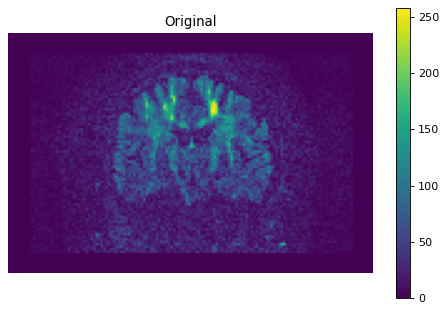

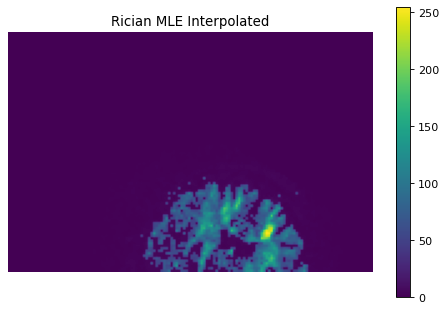

In [318]:
plt.figure(dpi=80)
plt.title("Original")
plt.imshow(np.rot90(pre_img[:, pre_img.shape[1] // 2, :]), interpolation=None)
plt.colorbar()
plt.axis("off")

plt.figure(dpi=80)
plt.title("Rician MLE Interpolated")
plt.imshow(np.rot90(rot_image[:, 2, :]), interpolation=None)
plt.colorbar()
plt.axis("off");

(-0.5, 145.5, 95.5, -0.5)

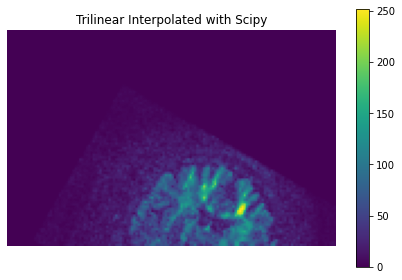

In [323]:
scipy_interp = scipy.ndimage.affine_transform(
    pre_img, back_affine, order=1, prefilter=False
)

plt.figure()
plt.title("Trilinear Interpolated with Scipy")
plt.imshow(np.rot90(scipy_interp[:, 148 // 2]), interpolation=None)
plt.colorbar()
plt.axis("off")

(-0.5, 145.5, 95.5, -0.5)

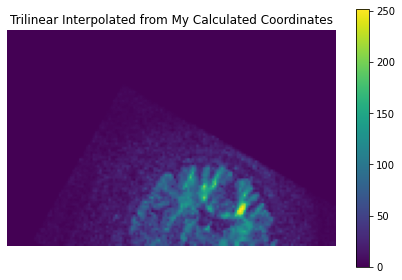

In [320]:
scipy_coord_interp = scipy.ndimage.map_coordinates(
    pre_img, pre_coords, order=1, prefilter=False
)
plt.figure()
plt.title("Trilinear Interpolated from My Calculated Coordinates")
plt.imshow(np.rot90(scipy_coord_interp[:, 148 // 2]), interpolation=None)
plt.colorbar()
plt.axis("off")

---

# Gradient Descent in Numpy

In [ ]:
def rician_nll(x, nu, noise_var):
    result = np.log(x / noise_var)
    result -= (x ** 2 + nu ** 2) / (2 * nu)
    result += np.log(scipy.special.i0(x * nu / noise_var))

    return -result


def weight_rician_nll(x, weights, nu, noise_var):
    """
    Find weighted negative log-likelihood for one voxel given several voxels in a patch.

    Parameters:
        x: np.ndarray, B x N
            Samples taken from real data, assumed to be Rician distributed
        weights: np.ndarray, B x N, with each batch summing to 1.0
            Weights to linearlly combine each sample
        nu: np.ndarray, B x 1
            Value of the "clean" signal
        noise_var: float
    """

    B = x.shape[0]
    samples = x.reshape(B, -1)
    pred = nu.reshape(B, 1)
    w = weights.reshape(*samples.shape)
    log_likes = rician_nll(samples, pred, noise_var)

    weight_log_likes = np.sum(w * log_likes)

    return weight_log_likes


def grad_weight_rician_nll(x, nu, weights, noise_var):
    """
    Parameters:
    x: np.ndarray, B x D_1 x D_2 x ... x D_m
        Samples taken from real data, assumed to be Rician distributed
    weights: np.ndarray, B x D_1 x D_2 x ... x D_m, with each batch summing to 1.0
        Weights to linearlly combine each sample
    nu: np.ndarray, B x 1
        Value of the "clean" signal
    noise_var: float
    """

    B = x.shape[0]
    samples = x.reshape(B, -1)
    pred = nu.reshape(B, 1)
    w = weights.reshape(*samples.shape)

    N = samples.shape[1]

    offset_term = -N * signal / noise_var
    inner_sum = (
        scipy.special.i1(samples * signal / noise_var)
        / scipy.special.i0(samples * signal / noise_var)
        * samples
        / noise_var
    )

    sum_term = np.sum(inner_sum)
    result = offset_term + sum_term

    return result

In [333]:
x = np.random.randint(0, 10, (10, 10)).astype(float)
x += x / 3
x

array([[ 5.33333333, 10.66666667,  5.33333333,  5.33333333,  0.        ,  0.        ,
        10.66666667,  5.33333333,  5.33333333, 10.66666667],
       [12.        ,  9.33333333,  0.        ,  9.33333333, 12.        ,  5.33333333,
         1.33333333,  0.        ,  2.66666667,  4.        ],
       [ 1.33333333, 10.66666667,  1.33333333,  1.33333333,  5.33333333,  1.33333333,
         0.        ,  5.33333333,  0.        ,  8.        ],
       [ 2.66666667,  1.33333333,  1.33333333,  8.        , 12.        ,  5.33333333,
         2.66666667,  1.33333333,  1.33333333,  8.        ],
       [12.        ,  8.        ,  6.66666667,  1.33333333,  8.        ,  5.33333333,
        10.66666667,  5.33333333,  9.33333333,  1.33333333],
       [12.        , 10.66666667,  1.33333333,  5.33333333,  6.66666667,  1.33333333,
        10.66666667,  8.        , 12.        , 12.        ],
       [ 1.33333333, 12.        , 10.66666667,  5.33333333,  2.66666667,  0.        ,
        12.        ,  8.        

$$
v_{t+1} = \mu * v_{t} + g_{t+1}, \\
p_{t+1} = p_{t} - \text{lr} * v_{t+1}
$$

In [ ]:
def batch_rician_mle(
    samples,
    weights,
    noise_var,
    init_pred=None,
    lr=0.01,
    momentum=0,
    tol=1e-5,
    max_steps=1000,
):
    """
    samples: np.ndarray, B x N
    weights: np.ndarray, B x N
    noise_var: float
    init_pred: np.ndarray, B x 1
    """

    # Set up dimensions to be the correct shape
    B = samples.shape[0]
    if len(weights.shape) == len(samples.shape) - 1:
        weights = np.repeat(weights[None, ...], B, axis=0)

    batch_samples = samples.reshape(B, -1)
    N = batch_samples.shape[1]

    weights = weights.reshape(B, N)

    if init_pred is None:
        init_pred = np.sum(batch_samples * weights, axis=1)

    nu_0 = np.asarray(init_pred).reshape(B, 1)

    return

In [ ]:
# def grad_interpolate(
#     patch,
#     interp_kernel,
#     noise_var,
#     lr,
#     momentum=0,
#     init_pred=None,
#     tol=1e-5,
#     max_steps=1000,
# ):
#     samples = patch.flatten()
#     weights = interp_kernel.flatten()
#     if init_pred is None:
#         init_pred = np.sum(samples * weights)

#     pred_t = init_pred
#     vel_t = 1 * momentum

#     for i in range(max_steps):
#         grad_tp1 = grad_weight_ll(samples, pred_t, noise_var)
#         if grad_tp1 <= tol:
#             return pred_t

#         vel_tp1 = momentum * vel_t + grad_tp1
#         pred_tp1 = pred_t - lr * vel_tp1

#         pred_t = pred_tp1
#         vel_t = vel_tp1

#     print(f"WARNING: Did not converge to tol {tol}")

#     return pred_t

In [ ]:
# class RicianNLL(torch.autograd.Function):
#     @staticmethod
#     def forward(ctx, pred_signals, samples, weights, noise_var):
#         """

#         Parameters:
#             samples: torch.Tensor with shape B x N
#             pred_signals: torch.Tensor with shape B
#             weights: torch.Tensor with shape B x N
#             noise_var: float
#         """
#         # ctx is a context object that can be used to stash information
#         # for backward computation
#         ctx.noise_var = noise_var
#         ctx.samples = samples
#         ctx.pred_signals = pred_signals

# #         breakpoint()

#         log_likes = torch.log(samples / noise_var)
#         log_likes = log_likes - (samples ** 2 + pred_signals.view(-1, 1) ** 2) / (
#             2 * noise_var
#         )

#         zero_bessel = scipy.special.i0(
#             (samples * pred_signals.view(-1, 1) / noise_var).cpu().numpy()
#         )
#         zero_bessel = torch.as_tensor(zero_bessel).to(log_likes)
#         ctx.zero_bessel = zero_bessel

#         log_likes = log_likes + torch.log(zero_bessel)

#         weight_log_likes = torch.sum(weights * log_likes, dim=1)

#         return -weight_log_likes

#     @staticmethod
#     def backward(ctx, grad_output):
#         # We return as many input gradients as there were arguments.
#         # Gradients of non-Tensor arguments to forward must be None.
#         samples = ctx.samples
#         N = len(samples)
#         pred_signals = ctx.pred_signals
#         noise_var = ctx.noise_var

#         offset_term = -N * pred_signals / noise_var

#         zero_bessel = ctx.zero_bessel
#         one_bessel = scipy.special.i1(
#             (samples * pred_signals.view(-1, 1) / noise_var).cpu().numpy()
#         )
#         one_bessel = torch.as_tensor(one_bessel).to(zero_bessel)

#         inner_sum = one_bessel / zero_bessel * samples / noise_var

#         sum_term = torch.sum(inner_sum, dim=1)
#         grads = offset_term + sum_term

#         return grads, None, None, None


# class RicianInterp(torch.nn.Module):
#     def __init__(self, init_signals):
#         super().__init__()

#         self.N = len(init_signals)
#         self.signals = torch.nn.Parameter(torch.as_tensor(init_signals))

#     def forward(
#         self, patches: torch.Tensor, interp_kernels: torch.Tensor, noise_var: float
#     ):
#         if interp_kernels.ndim == patches.ndim - 1:
#             interp_kernels = interp_kernels.expand_as(patches)

#         samples = patches.reshape(self.N, -1)
#         interp_kernels = interp_kernels.reshape(self.N, -1)

#         return RicianNLL.apply(self.signals, samples, interp_kernels, noise_var)